In [1]:
#First we load the libraries need
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
#Load the dataset from the tensorflow_datasets library with the info
df, info= tfds.load(name = 'cats_vs_dogs', with_info=True, split='train', as_supervised=True)

In [3]:
#Here we can see some information about the data of the data
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul,

In [4]:
#First, I load the images and their labels into two seperate lists so that I can inspect the data and have some visualizations
images =[]
labels= []
for example, label in df:
    images.append(example)
    labels.append(label)

In [5]:
labels= np.array(labels)
labels_df=pd.DataFrame(labels, columns=["Labels"])
labels_df.head()

,Labels
0,1
1,1
2,1
3,0
4,1


In [6]:
#With this code we can see what percentage of the images belong to dogs and what percentage belong to cats
labels_df['Labels'].value_counts(normalize=True)
#As seen in the info part as well, 0 stand for Cat and 1 is for Dogs so we can see that its almost a 50 50 split

0    0.501161
1    0.498839
Name: Labels, dtype: float64

In [7]:
#Change the labels which are integers to strings for the data vizualisation to make sense
labels_df["Labels"][labels_df["Labels"]==0]='Cat'
labels_df["Labels"][labels_df["Labels"]==1]='Dog'

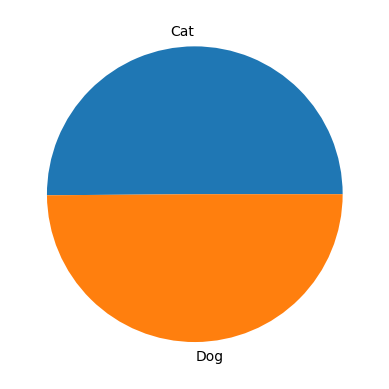

In [8]:
#We can also use a pie chart to see better that the imagws are almost split between cats and dogs
vc= labels_df['Labels'].value_counts()
plt.pie(vc.values, labels=vc.index);

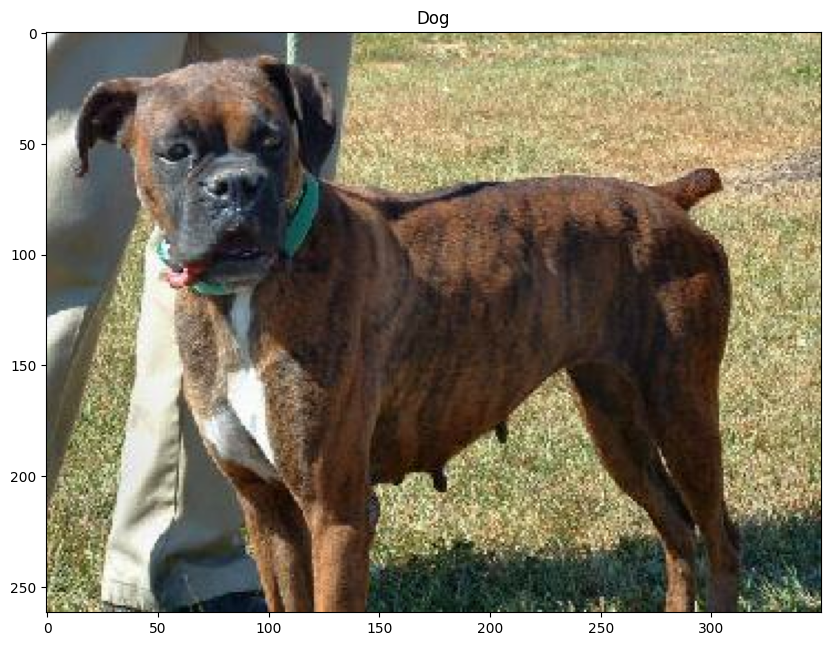

1


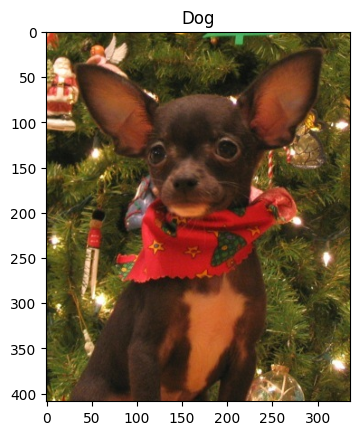

1


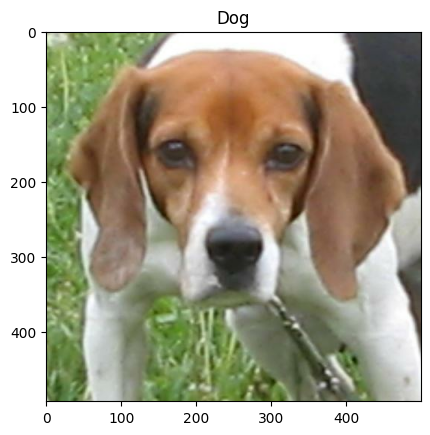

1


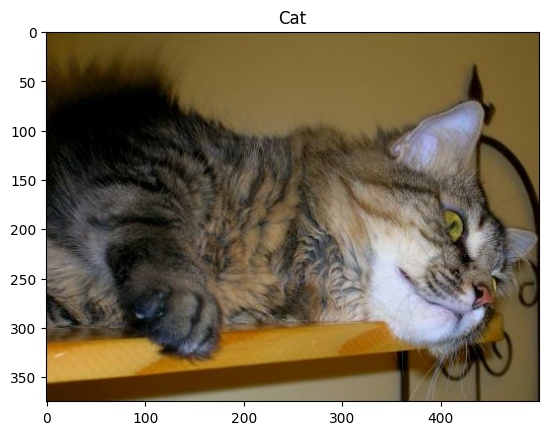

0


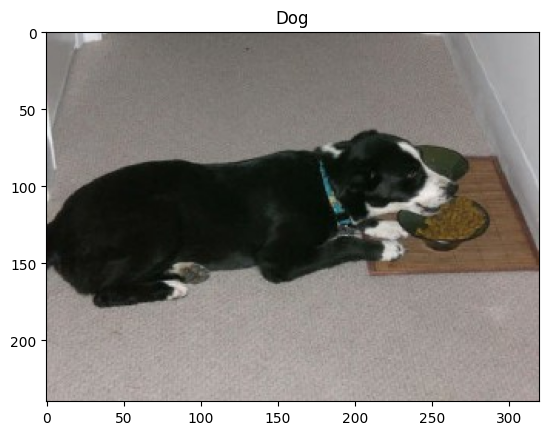

1


In [9]:
#Here we vizualise the first 6 images with their corresponding lables
plt.figure(figsize=(10, 10))
for i in range (5):
  img=images[i]
  label=labels[i]
  plt.imshow(img)
  plt.title(labels_df['Labels'][i])
  plt.show()
  print(label)

In [2]:
#We load the data agian as this time we split the data for training and testing
train= tfds.load('cats_vs_dogs',  split='train[80%:]', as_supervised=True)
test= tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteOWT7LT/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
#We write the "resize" function to turn all the pixels between 0 and one an dturn the images to the appropriat size to make it easier for processing
def resize(image, label):
    image = tf.image.resize(image, (160, 160))/255.0
    return image, tf.one_hot(label, 1)

In [4]:
train = train.map(resize).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.map(resize).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
#Now, we use the image augmentation technique:
#This technique is used when there are not alot of images and to avoid overfitting on certain insignificant features of the images
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.4),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

In [18]:
#We can use the weights of a pretrianed model which have been trained on million images and is more efficient and better designed
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3), include_top=False, weights='imagenet')
base_model.trainable=True
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.compile(optimizer =tf.keras.optimizers.Adam(), loss =tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
history = model.fit(train, epochs = 7, batch_size=64, validation_data= test)

Epoch 1/7
146/146 [==============================] - 550s 4s/step - loss: 0.3811 - accuracy: 0.8231 - val_loss: 0.3125 - val_accuracy: 0.8779
Epoch 2/7
146/146 [==============================] - 526s 4s/step - loss: 0.3042 - accuracy: 0.8633 - val_loss: 0.2547 - val_accuracy: 0.8845
Epoch 3/7
146/146 [==============================] - 529s 4s/step - loss: 0.2233 - accuracy: 0.9058 - val_loss: 0.2611 - val_accuracy: 0.8732
Epoch 4/7
146/146 [==============================] - 528s 4s/step - loss: 0.1803 - accuracy: 0.9207 - val_loss: 0.2151 - val_accuracy: 0.9119
Epoch 5/7
146/146 [==============================] - 528s 4s/step - loss: 0.1582 - accuracy: 0.9351 - val_loss: 0.2004 - val_accuracy: 0.9190
Epoch 6/7
146/146 [==============================] - 527s 4s/step - loss: 0.1527 - accuracy: 0.9286 - val_loss: 0.1884 - val_accuracy: 0.9223
Epoch 7/7
146/146 [==============================] - 536s 4s/step - loss: 0.1467 - accuracy: 0.9362 - val_loss: 0.2016 - val_accuracy: 0.9187


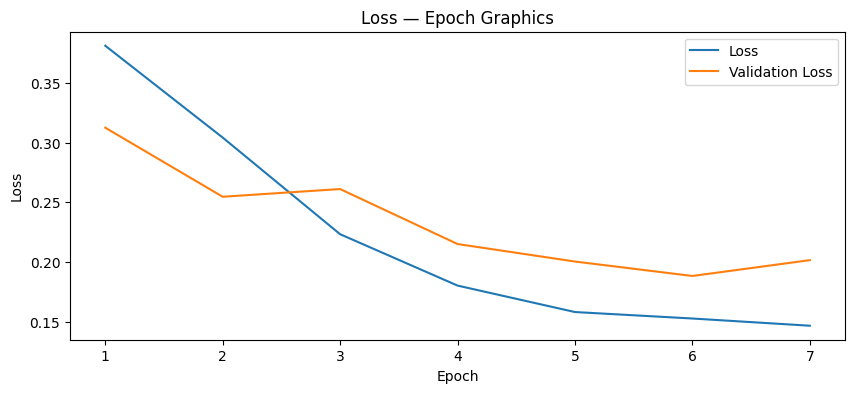

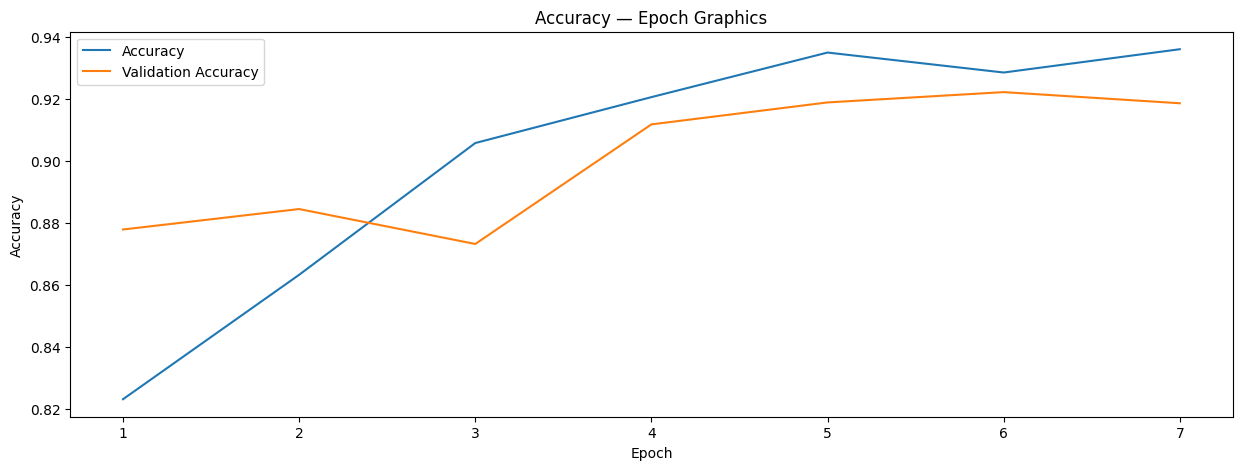

In [29]:
figure = plt.gcf()
figure.set_size_inches((10, 4))
plt.title('Loss — Epoch Graphics')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.show()
figure = plt.gcf()
figure.set_size_inches((15, 5))
plt.title('Accuracy — Epoch Graphics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()